============================================================================================

# Kmeans

============================================================================================


In [1]:
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
import pandas as pd
import numpy as np
import os
import re
import random
import time
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.decomposition import PCA

import fns_models as fns


% matplotlib inline

from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf-8"))

athenaeum_authors.csv
athenaeum_authors_preview.csv
athenaeum_painting_filtered.csv
athenaeum_painting_movement.csv
athenaeum_painting_movement_test.csv
athenaeum_painting_movement_train.csv
athenaeum_paintings.csv
athenaeum_paintings_sizes.csv
color_hist_kmeans_206552.csv
color_histograms.csv
color_hist_size_206552.csv
complete_data.csv
extra_tree_com.csv
grad_boost_com.csv
images
images_athenaeum
images_sizes_2325.csv
kmeans_centers.csv
kmeans.png
knn_com.csv
model_accuracy.csv
movement_hist_test.csv
movement_hist_train.csv
nbc_com.csv
net_predicted.csv
painter_info_clean.csv
painting_info_clean.csv
pca20_kmeans_test.csv
pca20_kmeans_train.csv
resized_200
rf_com.csv
test_author200.csv
test_data.csv
test_hist_author_knn.csv
test_hist_author_rf.csv
train_author200.csv
train_data.csv
train_hist_author_knn.csv
train_hist_author_rf.csv
xgb_com.csv



In [ ]:
def plot_columns(sample_painting):
    from PIL import Image
    if len(sample_painting) > 8:
        sample_painting = sample_painting.sample(8)
    elif len(sample_painting) == 0:
        print "[INFO]: No painting for this cluster!"
        return
    size = len(sample_painting)
    y = 1 if size <= 4 else 2
    x = size if y == 1 else (size + 1) // 2
    f, ax = plt.subplots(y, x, figsize = (20,15))
    for i in range(size):
        im = Image.open('data/images_athenaeum/full/%d/%d.jpg' % (sample_painting.iloc[i]['author_id'],
                                                                  sample_painting.iloc[i]['painting_id']))
        if size == 1:
            curAxis = ax
        elif y == 1:
            curAxis = ax[i]
        else:
            curAxis = ax[i / x, i % x]
        curAxis.imshow(im)
        curAxis.set_yticks([])
        curAxis.set_xticks([])

In [3]:
test_id = pd.read_csv('data/test_hist_author_knn.csv')
train_id = pd.read_csv('data/train_hist_author_knn.csv')
test_id.head(1)

,author_id,painting_id,hist_01,hist_02,hist_03,hist_04,hist_05,hist_06,hist_07,hist_08,...,hist_24,hist_25,hist_26,hist_27,hist_28,hist_29,hist_30,height_px,width_px,height_width_ratio
0,444,12077,7603,1687,587,348,403,538,671,959,...,69539,24143,46874,97427,117568,102332,79799,555,800,0.69375


In [4]:
color_hist = pd.read_csv('data/color_hist_kmeans_206552.csv')
color_hist.head(3)

,author_id,painting_id,hist_01,hist_02,hist_03,hist_04,hist_05,hist_06,hist_07,hist_08,...,hist_23,hist_24,hist_25,hist_26,hist_27,hist_28,hist_29,hist_30,height_width_ratio,kmeans_labels
0,444,12077,0.017124,0.003800,0.001322,0.000784,0.000908,0.001212,0.001511,0.002160,...,0.223286,0.156619,0.054376,0.105572,0.219430,0.264793,0.230477,0.179727,0.693750,6
1,444,11653,0.200286,0.151817,0.005062,0.001460,0.001430,0.005501,0.000804,0.003752,...,0.203864,0.140315,0.066314,0.035917,0.089287,0.095728,0.098622,0.680446,0.779412,0
2,444,12097,0.002115,0.001055,0.000888,0.000860,0.002016,0.004890,0.012255,0.023900,...,0.258533,0.159779,0.075992,0.114563,0.189451,0.218488,0.254685,0.222813,1.310585,2


In [ ]:
print train_id.shape
print test_id.shape
print color_hist.shape

In [5]:
# find the train, test data for the tsne
train_tsne = color_hist.merge(pd.DataFrame(train_id.iloc[:, 1]), how='inner', on='painting_id')
test_tsne = color_hist.merge(pd.DataFrame(test_id.iloc[:, 1]), how='inner', on='painting_id')
print train_tsne.shape
print test_tsne.shape

train_tsne.head(1)

(49890, 34)
(12473, 34)


,author_id,painting_id,hist_01,hist_02,hist_03,hist_04,hist_05,hist_06,hist_07,hist_08,...,hist_23,hist_24,hist_25,hist_26,hist_27,hist_28,hist_29,hist_30,height_width_ratio,kmeans_labels
0,444,11653,0.200286,0.151817,0.005062,0.00146,0.00143,0.005501,0.000804,0.003752,...,0.203864,0.140315,0.066314,0.035917,0.089287,0.095728,0.098622,0.680446,0.779412,0


In [ ]:
# filtered_out = ['height_px', 'width_px']
# color_hist = color_hist.drop(filtered_out, axis=1)
color_hist['kmeans_labels'] = kmeans.labels_
print color_hist.shape
color_hist.to_csv('data/color_hist_kmeans_206552.csv', index=False)

In [6]:
color_hist.iloc[:,2:-2] = color_hist.iloc[:, 2:-2]\
        .apply(lambda x: x.astype(np.float) / (x.sum()/3), axis = 1, raw = True)

# movement_hist_test.iloc[:,3:-1] = movement_hist_test.iloc[:, 3:-1]\
#             .apply(lambda x: x.astype(np.float) / (x.sum()/3), axis = 1, raw = True)

In [7]:
color_hist.head(3)

,author_id,painting_id,hist_01,hist_02,hist_03,hist_04,hist_05,hist_06,hist_07,hist_08,...,hist_23,hist_24,hist_25,hist_26,hist_27,hist_28,hist_29,hist_30,height_width_ratio,kmeans_labels
0,444,12077,0.017124,0.003800,0.001322,0.000784,0.000908,0.001212,0.001511,0.002160,...,0.223286,0.156619,0.054376,0.105572,0.219430,0.264793,0.230477,0.179727,0.693750,6
1,444,11653,0.200286,0.151817,0.005062,0.001460,0.001430,0.005501,0.000804,0.003752,...,0.203864,0.140315,0.066314,0.035917,0.089287,0.095728,0.098622,0.680446,0.779412,0
2,444,12097,0.002115,0.001055,0.000888,0.000860,0.002016,0.004890,0.012255,0.023900,...,0.258533,0.159779,0.075992,0.114563,0.189451,0.218488,0.254685,0.222813,1.310585,2


In [ ]:
%%time
# prepare Kmeans data
kmeans = KMeans(n_init = 100, n_jobs=4)
kmeans.set_params(n_clusters=7)
kmeans.fit(color_hist.iloc[:, 2:-1])

In [ ]:
print (kmeans.labels_).shape
kmeans.labels_

In [ ]:
color_hist.iloc[:, 2:].columns

In [ ]:
kmeans.cluster_centers_.shape

In [ ]:
# pd.DataFrame(kmeans.cluster_centers_).to_csv('data/kmeans_centers.csv', index=False)

In [ ]:
def get_paintings_around_centroid(centroid, color_hist, num_paintings):
    distances = color_hist.iloc[:, 2:-1].apply(lambda row: sum((row - centroid) ** 2), raw = True, axis = 1)
    return color_hist.loc[distances.sort_values()[:num_paintings].index, ['painting_id', 'author_id']]

In [ ]:
def get_paintings_around_centroid(centroid, color_hist, num_paintings):
    distances = color_hist.iloc[:, 2:-1].apply(lambda row: sum((row - centroid) ** 2), raw = True, axis = 1)
    return color_hist.loc[distances.nsmallest(num_paintings).index, ['painting_id', 'author_id']]

In [ ]:
%%time
plot_columns(get_paintings_around_centroid(kmeans.cluster_centers_[0], color_hist, 4))

In [ ]:
%%time
plot_columns(get_paintings_around_centroid(kmeans.cluster_centers_[1], color_hist, 4))

In [ ]:
%%time
plot_columns(get_paintings_around_centroid(kmeans.cluster_centers_[2], color_hist, 4))

In [ ]:
%%time
plot_columns(get_paintings_around_centroid(kmeans.cluster_centers_[3], color_hist, 4))

In [ ]:
%%time
plot_columns(get_paintings_around_centroid(kmeans.cluster_centers_[4], color_hist, 4))

In [ ]:
%%time
plot_columns(get_paintings_around_centroid(kmeans.cluster_centers_[5], color_hist, 4))

In [ ]:
%%time
plot_columns(get_paintings_around_centroid(kmeans.cluster_centers_[6], color_hist, 4))

In [ ]:
def plot_columns_kmeans(centroids, color_hist, num_per_cluster, art_movements = None):
    base_dim = 18
    from PIL import Image
    f, ax = plt.subplots(centroids.shape[0], num_per_cluster,
                         figsize = (base_dim, base_dim * centroids.shape[0] / num_per_cluster))
    for y, centroid in enumerate(centroids):
        paintings = get_paintings_around_centroid(centroid, color_hist, num_per_cluster)
        if art_movements is not None:
            paintings = paintings.merge(art_movements[['author_id', 'painting_id', 'sup_art_movement']], how = 'left',
                                        on = ['author_id', 'painting_id'])
        for i in range(len(paintings)):
            im = Image.open('data/images_athenaeum/full/%d/%d.jpg' % (paintings.iloc[i]['author_id'],
                                                                  paintings.iloc[i]['painting_id']))
            curAxis = ax[y, i] if num_per_cluster > 1 else ax[y]
            curAxis.imshow(im)
            curAxis.set_yticks([])
            curAxis.set_xticks([])
            if art_movements is not None:
                curAxis.set_title(paintings.iloc[i]['sup_art_movement'])
            if i == 0:
                curAxis.set_ylabel('cluster #%d' % y)

In [ ]:
color_hist.head(1)

In [ ]:
%%time
plot_columns_kmeans(kmeans.cluster_centers_, color_hist, 8, art_movements=pd.read_csv('data/athenaeum_painting_movement.csv'))

In [ ]:
# calculate the distance
kmeans_centers = pd.read_csv('data/kmeans_centers.csv')
kmeans_centers.head(1)

In [ ]:
color_hist[color_hist['kmeans_labels'] == 0].iloc[:, 2:-1].shape

# TSNE for cluster plotting

In [ ]:
# Memory error
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
tsne.fit_transform(color_hist.iloc[:, 1:]) 

In [8]:
tsne_data = pd.concat([train_tsne.reset_index(drop=True), test_tsne], axis=0)
print tsne_data.shape
tsne_data.head(1)

(62363, 34)


,author_id,painting_id,hist_01,hist_02,hist_03,hist_04,hist_05,hist_06,hist_07,hist_08,...,hist_23,hist_24,hist_25,hist_26,hist_27,hist_28,hist_29,hist_30,height_width_ratio,kmeans_labels
0,444,11653,0.200286,0.151817,0.005062,0.00146,0.00143,0.005501,0.000804,0.003752,...,0.203864,0.140315,0.066314,0.035917,0.089287,0.095728,0.098622,0.680446,0.779412,0


In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
tsne_trainsformed = tsne.fit_transform(tsne_data.iloc[:, 2:-1].sample(5000,random_state = 123)) 

In [10]:
tsne_data.head(1)

,author_id,painting_id,hist_01,hist_02,hist_03,hist_04,hist_05,hist_06,hist_07,hist_08,...,hist_23,hist_24,hist_25,hist_26,hist_27,hist_28,hist_29,hist_30,height_width_ratio,kmeans_labels
0,444,11653,0.200286,0.151817,0.005062,0.00146,0.00143,0.005501,0.000804,0.003752,...,0.203864,0.140315,0.066314,0.035917,0.089287,0.095728,0.098622,0.680446,0.779412,0


In [30]:
from time import time
from sklearn.manifold import TSNE

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = TSNE(n_components=2, init='pca', random_state=2017)
trans_data = tsne.fit_transform(tsne_data.iloc[:, 2:-1].sample(5000)).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = plt.figure(figsize=(15, 8))


t-SNE: 51 sec


In [21]:
tsne_trainsformed

array([[-10.64951636,  -5.31669866],
       [  9.11792885,   1.99588803],
       [ -9.0820418 ,  -0.95013157],
       ..., 
       [ -2.62154483,   4.17409881],
       [  5.32965639,  -7.07745697],
       [-10.96002888,  -0.31014424]])

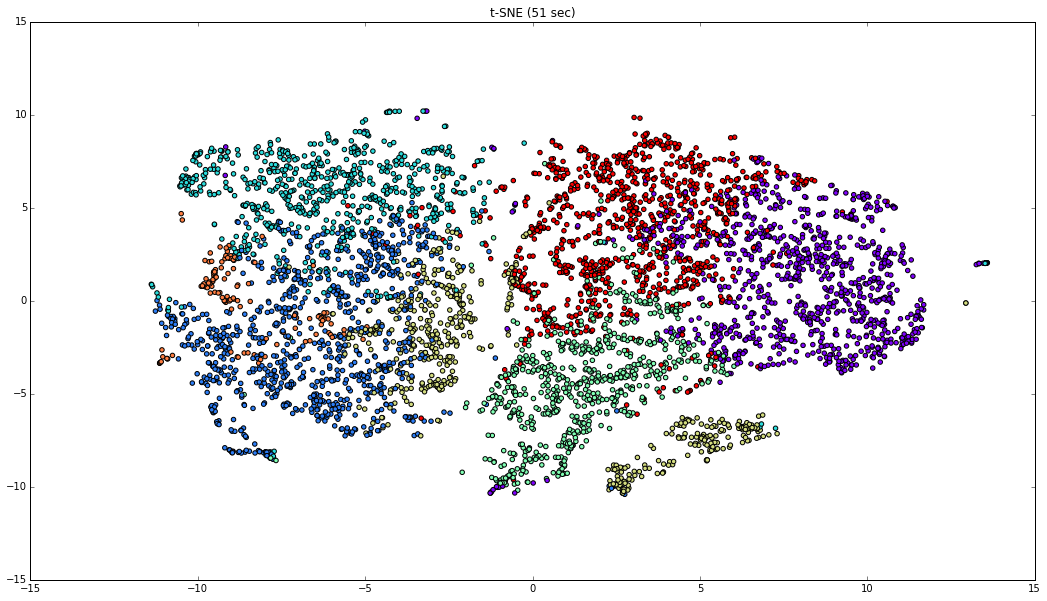

In [32]:
colors = tsne_data.iloc[:, -1].sample(5000,random_state = 123)
fig = plt.figure(figsize=(18, 10))

plt.scatter(tsne_trainsformed[:,0], tsne_trainsformed[:,1],
            c=np.array(colors), 
            cmap=plt.cm.rainbow)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.axis('normal')
plt.show()
fig.savefig('data/kmeans_tsne.png', dpi=fig.dpi)


In [ ]:
tsne_data.head(2)

In [ ]:
np.array(colors)

t-SNE: 0.64 sec


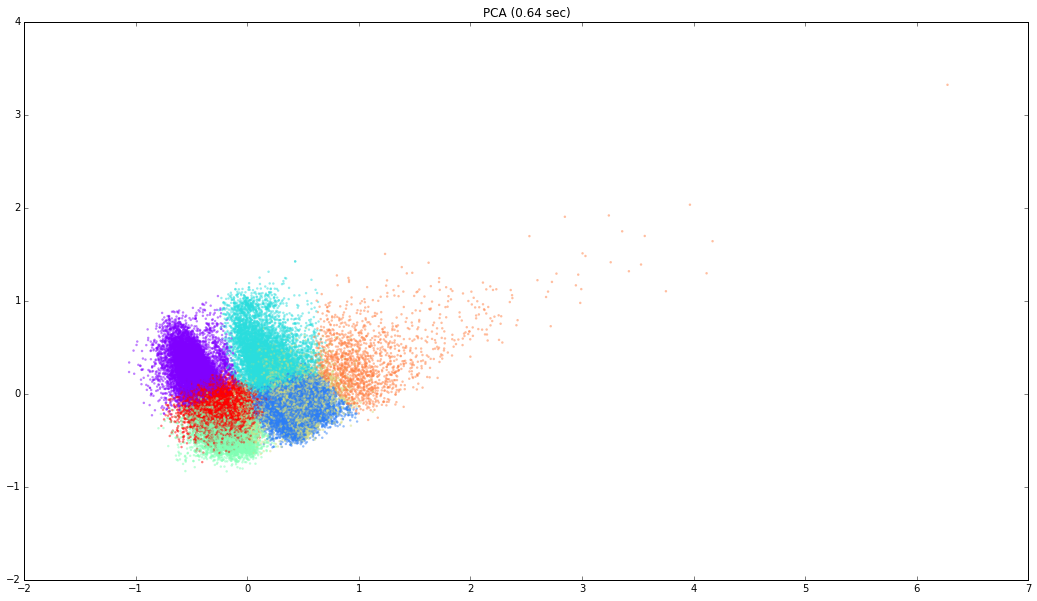

In [41]:
from time import time
t0 = time()
## Get 2 principal components

subset = np.random.choice(range(tsne_data.shape[0]), size = 5000)
pca = PCA(n_components=2, random_state=2017)
pca.fit(tsne_data.iloc[:,2:-1])
pca_transformed = pca.transform(tsne_data.iloc[:, 2:-1])#[subset]

t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = plt.figure(figsize=(15, 8))
colors = tsne_data.iloc[:, -1]
fig = plt.figure(figsize=(18, 10))
plt.scatter(pca_transformed[:,0], pca_transformed[:,1]
            ,
            c=np.array(colors), 
            cmap=plt.cm.rainbow,
            alpha = 0.5, lw = 0, s = 6
           )
plt.title("PCA (%.2g sec)" % (t1 - t0))
plt.axis('normal')
plt.show()

# fig.savefig('data/kmeans.png', dpi=fig.dpi)


In [ ]:
cluster_data = tsne_data.sample(5000,random_state = 123)
cluster_data.groupby(['painting_id', 'kmeans_labels']).agg('sum').head(3)

In [ ]:
cluster_data[cluster_data['author_id'] == 24]['kmeans_labels'].value_counts()

In [ ]:
authors = pd.read_csv('data/athenaeum_authors.csv')
sum(authors.first_name == 'Vincent')

In [ ]:
authors[authors.last_name == 'Gogh']

In [ ]:
authors[authors.last_name == 'Monet']

## Van Gogh Analysis

In [ ]:
van_gogh_data = cluster_data[cluster_data['author_id'] == 789][['author_id', 'painting_id' ,'kmeans_labels']]
van_gogh_data.head(5)

In [ ]:
van_gogh_data.iloc[:, 1:].groupby(['kmeans_labels']).agg('count').reset_index().rename(columns={'painting_id':'painting_num'})

In [ ]:
van_gogh_clusters = {}
for i in range(7):
    name = 'van_gogh_%d' % i
    van_gogh_clusters[name] = van_gogh_data[van_gogh_data['kmeans_labels'] == i]
    
# van_gogh_clusters

In [ ]:
plot_columns(van_gogh_clusters['van_gogh_0'])

In [ ]:
plot_columns(van_gogh_clusters['van_gogh_1'])

In [ ]:
plot_columns(van_gogh_clusters['van_gogh_2'])

In [ ]:
plot_columns(van_gogh_clusters['van_gogh_3'])

In [ ]:
plot_columns(van_gogh_clusters['van_gogh_4'])

In [ ]:
# No cluster 5 for van gogh
plot_columns(van_gogh_clusters['van_gogh_5'])

In [ ]:
plot_columns(van_gogh_clusters['van_gogh_6'])

In [ ]:
van_gogh_6 = van_gogh_data[van_gogh_data['kmeans_labels'] == 6]
van_gogh_6.head(3)

## Monet Analysis

In [ ]:
Monet_data = cluster_data[cluster_data['author_id'] == 13][['author_id', 'painting_id' ,'kmeans_labels']]
Monet_data.head(3)

In [ ]:
Monet_data.iloc[:, 1:].groupby(['kmeans_labels']).agg('count').reset_index().rename(columns={'painting_id':'painting_num'})

In [ ]:
monet_clusters = {}
for i in range(7):
    name = 'monet_%d' % i
    monet_clusters[name] = Monet_data[Monet_data['kmeans_labels'] == i]
    
# monet_clusters    

In [ ]:
plot_columns(monet_clusters['monet_0'])

In [ ]:
plot_columns(monet_clusters['monet_1'])

In [ ]:
plot_columns(monet_clusters['monet_2'])

In [ ]:
plot_columns(monet_clusters['monet_3'])

In [ ]:
plot_columns(monet_clusters['monet_4'])

In [ ]:
plot_columns(monet_clusters['monet_5'])

In [ ]:
plot_columns(monet_clusters['monet_6'])

# clusters for paintings

In [ ]:
cluster_data.head(2)

In [ ]:
cluster_data[['painting_id', 'kmeans_labels']].groupby('kmeans_labels').agg('count').rename(columns={'painting_id': 'painting_num'})

In [ ]:
cluster_data[cluster_data['kmeans_labels'] == 0].head(3)

In [ ]:
paintings_clusters = {}
for i in range(7):
    name = 'cluster_%d' % i
    paintings_clusters[name] = cluster_data[cluster_data['kmeans_labels'] == i]
    
# paintings_clusters  

In [ ]:
plot_columns(paintings_clusters['cluster_0'])

In [ ]:
plot_columns(paintings_clusters['cluster_1'])

In [ ]:
plot_columns(paintings_clusters['cluster_2'])

In [ ]:
plot_columns(paintings_clusters['cluster_3'])

In [ ]:
plot_columns(paintings_clusters['cluster_4'])

In [ ]:
plot_columns(paintings_clusters['cluster_5'])

In [ ]:
plot_columns(paintings_clusters['cluster_6'])

In [ ]:
color_hist.loc[:,'painting_id']
distances.nsmallest(4).index